In [584]:
import numpy as np
import random
from time import sleep
from ipythonblocks import BlockGrid
from IPython.display import clear_output
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim

In [585]:
# Define the Q-Network
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input is the (x, y) position of the agent
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)  # Output is the Q-value for each action (up, down, left, right)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Agent class for DQN
class DQNAgent:
    def __init__(self):
        self.model = DQN()
        self.target_model = DQN()  # Target network for stable training
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.update_target_every = 10
        self.steps = 0

        self.name = "Deep Q Agent"

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_action(self, state):
        return self.act(state)
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice([0, 1, 2, 3])  # Random action (explore)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        return torch.argmax(q_values).item()  # Choose action with highest Q-value (exploit)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = self.model(state)
            with torch.no_grad():
                target_next = self.target_model(next_state)

            target[0][action] = reward + (self.gamma * torch.max(target_next)) * (1 - done)

            self.optimizer.zero_grad()
            loss = self.loss_fn(self.model(state), target)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())


In [586]:
class FLMapperAgent():
    def __init__(self, name:str = "Mapped agent"):
        self.name = name

    def get_action(self, state):
        direction = {"up": 0, "down": 1, "left": 2, "right": 3}
        choice = ""
        match  tuple(state):
            case (0, 0):
                choice = "left"
            case (1, 0):
                choice = "up"
            case (2, 0):
                choice = "up"
            case (3, 0):
                choice = "up"
            case (0, 1):
                choice = "left"
            case (2, 1):
                choice = "left"
            case (0, 2):
                choice = "up"
            case (1, 2):
                choice = "down"
            case (2, 2):
                choice = "left"
            case (1, 3):
                choice = "right"
            case (2, 3):
                choice = "down"
            case _:
                choice = "up"
        return direction[choice]

In [587]:
class FLMoveRankAgent():
    def __init__(self, model, name:str = "Move ranking agent"):
        self.model = model
        self.name = name
        
    def get_positions_from_choice(self, state, decision):
        positions = []

        new_position = state + self.model.decision_dict[decision]
        if not ((new_position == (-1, -1)).any() or (new_position == (4, 4)).any()):
            positions.append(new_position)
        
        current_pos = tuple(state)
        # Can only slip perpendicular to direction move is attempted
        if (decision == "up" or decision == "down"):
            positions.append((min(current_pos[0] + 1, 3), current_pos[1]))
            positions.append((max(current_pos[0] - 1, 0), current_pos[1]))
        if (decision == "left" or decision == "right"):
            positions.append((current_pos[0], min(current_pos[1] + 1, 3)))
            positions.append((current_pos[0], max(current_pos[1] - 1, 0)))

        return positions

    def rate_position(self, position):
        # Larger positions are closer to goal
        score = position[0] + position[1]

        if self.model.in_pit(np.array(position)):
            score -= 150
        if self.model.is_complete(np.array(position)):
            score += 5000  # Goal reached

        return score

    def get_action(self, state):
        direction_to_num = {"up": 0, "down": 1, "left": 2, "right": 3}

        pos_next_positions = {"up": [], "down": [], "left": [], "right": []}
        choice_scores = {"up": 0, "down": 0, "left": 0, "right": 0}
        
        for key in pos_next_positions.keys():
            pos_next_positions[key] = self.get_positions_from_choice(state, key)
            for pos in pos_next_positions[key]:
                choice_scores[key] += self.rate_position(pos)

        best = max(choice_scores, key=choice_scores.get)

        choice_scores = dict(sorted(choice_scores.items(), key=lambda item: -item[1]))
        
        return direction_to_num[best]
        

In [588]:
class FLRecursiveRank(FLMoveRankAgent):
    def __init__(self, model, name:str = "Move ranking recursive agent"):
        self.model = model
        self.name = name

    def rate_position(self, position, evaluated:dict = {}, alpha:float = 0.1, depth:int = 0, max_depth:int = 500):
        if depth > max_depth:
            return 0
        else:
            depth += 1

        # Larger positions are closer to goal
        score = position[0] + position[1]

        if self.model.in_pit(np.array(position)):
            score -= 150
            return score
        if self.model.is_complete(np.array(position)):
            score += 5000  # Goal reached
            return score
        
        if tuple(position) in evaluated.keys():
            return evaluated[tuple(position)]

        # Add fractional score of all subsequently reachable positions
        for dir in ["up", "down", "left", "right"]:
            for next_pos in self.get_positions_from_choice(position, dir):
                score += self.rate_position(next_pos, depth=depth) * alpha
        
        # Maintain list of position - score pairs to speed up search
        evaluated[tuple(position)] = score
        return score
        

In [589]:
class FLRandomAgent():
    def __init__(self, name:str = "Random agent"):
        self.name = name
        
    def get_action(self, state):
        return random.choice([0, 1, 2, 3])

In [590]:
class FLModel:
    def __init__(self):
        self.decision_dict = {"up": np.array((0, -1)), "down": np.array((0, 1)), "left": np.array((-1, 0)), "right": np.array((1, 0))}

        self.goal_position = (3, 3)
        self.pit_positions = ((1,1), (3,1), (3, 2), (0, 3))

    def exog_info(self, state, decision):
        if random.random() < 0.667:
            return "slip"
        else:
            return "move"

    def get_reward(self, state):
        if self.in_pit(state):
            return -25
        if self.is_complete(state):
            return 50  # Goal reached
        
        return -0.1  # Small penalty for each move
    
    def in_pit(self, state):
        return tuple(state) in self.pit_positions

    def transition_function(self, state, decision, exog_info):
        if exog_info != "slip":
            new_position = state + self.decision_dict[decision]
            if not ((new_position == (-1, -1)).any() or (new_position == (4, 4)).any()):
                return new_position
        
        current_pos = tuple(state)
        # Can only slip perpendicular to direction move is attempted
        possible_positions = []
        if (decision == "up" or decision == "down"):
            possible_positions.append((min(current_pos[0] + 1, 3), current_pos[1]))
            possible_positions.append((max(current_pos[0] - 1, 0), current_pos[1]))
        if (decision == "left" or decision == "right"):
            possible_positions.append((current_pos[0], min(current_pos[1] + 1, 3)))
            possible_positions.append((current_pos[0], max(current_pos[1] - 1, 0)))

        slip_position = random.choice(possible_positions)
        return np.array(slip_position)

    def is_complete(self, state):
        return (state == (3, 3)).all()

    def draw_state(self, state):
        agent_colour = (0, 0, 255)
        goal_colour = (210, 30, 30)
        pit_colour = (30, 30, 30)
        clean_colour = (255, 255, 255)
        
        # Create the grid with the given width and height
        grid = BlockGrid(4, 4, fill=clean_colour)
        
        agent_position = state
        
        # Set the agent's position with its color
        grid[self.goal_position[1], self.goal_position[0]] = goal_colour
        grid[int(agent_position[1]), int(agent_position[0])] = agent_colour

        for pit in self.pit_positions:
            grid[pit[1], pit[0]] = pit_colour
        
        clear_output(wait=True)
        
        # Show the grid
        grid.show()
        
        # Add a small delay for visualization purposes
        sleep(0.5)

    
    # Method to run the trained agent in the environment and visualize
    def view_trained_agent(self, S0, agent, n_iterations: int = 200):
        current_state = S0
        for n in range(n_iterations):
            self.draw_state(current_state)  # Visualize the state
            action = agent.get_action(current_state)  # Let the trained agent decide an action
            action_name = ["up", "down", "left", "right"][action]  # Convert action index to action name
            exog = self.exog_info(current_state, action_name)  # Get external environment info
            current_state = self.transition_function(current_state, action_name, exog)  # Transition to next state
            
            if self.in_pit(current_state):  # Check if pit is hit
                self.draw_state(current_state)  # Final state visualization
                print(f"Fell in pit on step {n+1}!")
                break

            if self.is_complete(current_state):  # Check if goal is reached
                self.draw_state(current_state)  # Final state visualization
                print(f"Goal reached in {n+1} steps!")
                break
        else:
            print("Agent did not reach the goal.")

    
        # Method to run the trained agent in the environment and visualize
    def test_agent(self, S0, agent, view: bool = True, n_iterations: int = 200):
        total_completions = 0
        for n in range(n_iterations):
            current_state = S0
            for i in range(200): # Allow up to 200 steps to reach goal
                action = agent.get_action(current_state)  # Let the trained agent decide an action
                action_name = ["up", "down", "left", "right"][action]  # Convert action index to action name
                exog = self.exog_info(current_state, action_name)  # Get external environment info
                current_state = self.transition_function(current_state, action_name, exog)  # Transition to next state
                
                if self.in_pit(current_state):  # Check if pit is hit
                    break

                if self.is_complete(current_state):  # Check if goal is reached
                    total_completions += 1
                    break
        return total_completions/n_iterations

In [591]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch

# Function to visualize the current policy of the agent
def visualize_policy(agent):
    grid_size = 4
    actions = ['↑', '↓', '←', '→']  # Symbols for up, down, left, right

    # Initialize a grid to store the best action at each (x, y) position
    policy_grid = np.empty((grid_size, grid_size), dtype=str)

    # Loop over each state in the 4x4 grid
    for x in range(grid_size):
        for y in range(grid_size):
            state = np.array([x, y])  # The state is the (x, y) position
            state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Convert to tensor
            q_values = agent.model(state_tensor)  # Get Q-values for this state from the model
            best_action = torch.argmax(q_values).item()  # Get the action with the highest Q-value
            policy_grid[y, x] = actions[best_action]  # Store the best action using arrows

    # Create the plot to visualize the policy
    plt.figure(figsize=(5, 5))
    for x in range(grid_size):
        for y in range(grid_size):
            plt.text(x, y, policy_grid[y, x], fontsize=20, ha='center', va='center')

    # Set grid and labels
    plt.xlim(-0.5, grid_size - 0.5)
    plt.ylim(-0.5, grid_size - 0.5)
    plt.gca().invert_yaxis()  # Invert y-axis to match usual grid layout
    plt.grid(True)
    plt.xticks(np.arange(grid_size))
    plt.yticks(np.arange(grid_size))
    plt.title("Best Action per State (x, y)")
    plt.show()

# Main training function with policy visualization
def train_agent(model):
    # Training loop
    env = model
    agent = DQNAgent()
    start_state = np.array((0, 0))

    episode_rewards = []
    n_episodes = 1500

    # set up matplotlib for interactive plotting
    plt.ion()
    is_ipython = 'inline' in plt.get_backend()

    for episode in range(n_episodes):
        state = start_state
        done = False
        total_reward = 0

        while not done:
            action = agent.act(state)
            action_name = ["up", "down", "left", "right"][action]
            exog = env.exog_info(state, action_name)
            next_state = env.transition_function(state, action_name, exog)
            reward = env.get_reward(next_state)
            done = env.is_complete(next_state) or env.in_pit(next_state)
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                episode_rewards.append(total_reward)
                break

        agent.replay()
        if episode % agent.update_target_every == 0:
            agent.update_target_network()

        # Plot only every 5 episodes
        if (episode + 1) % 5 == 0:
            plt.figure(1)
            plt.clf()  # Clear the plot for fresh plotting
            plt.title('Training...')
            plt.xlabel('Episode')
            plt.ylabel('Total Reward')

            # Convert episode_rewards to a tensor for plotting
            rewards_t = torch.tensor(episode_rewards, dtype=torch.float)

            # Plot episode rewards
            plt.plot(rewards_t.numpy())

            # Plot the running average of rewards
            ave_over_last = 200
            if len(rewards_t) >= ave_over_last:
                running_avg_rewards = np.convolve(episode_rewards, np.ones(ave_over_last) / ave_over_last, mode='valid')
                plt.plot(running_avg_rewards, label=f"Running Avg (Last {ave_over_last})", color='orange')

            plt.pause(0.001)  # Pause to update the plot
            visualize_policy(agent)  # Visualize the policy
            display.display(plt.gcf())
            display.clear_output(wait=True)

    # After training is done, turn off interactive mode and display the final result
    # plt.ioff()
    display.display(plt.gcf())
    plt.show()

    # Visualize the final policy
    visualize_policy(agent)

    return agent

In [592]:
frozen_lake_model = FLModel()

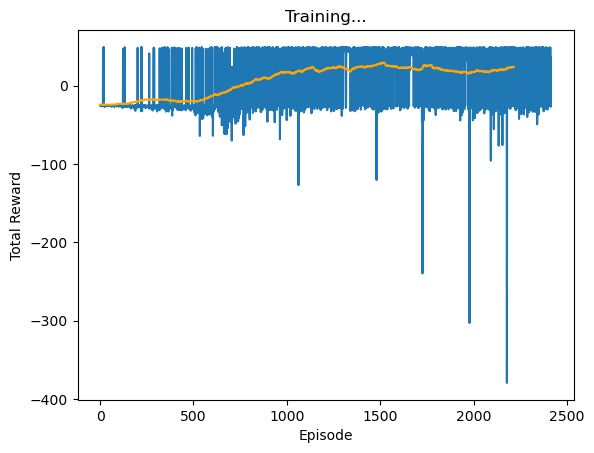

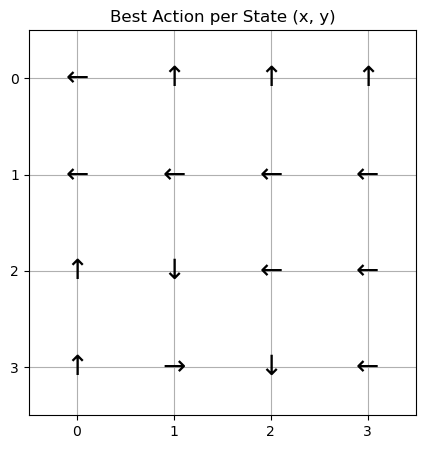

<Figure size 640x480 with 0 Axes>

In [ ]:
import pickle

def save_model(agent):
    with open("trained_agent.pkl", "ab") as file:
        pickle.dump(agent, file)

load = False

if load:
    with open("trained_agent.pkl", "rb") as file:
        trained_agent = pickle.load(file)
else:
    trained_agent = train_agent(frozen_lake_model)


In [582]:
random_agent = FLRandomAgent()
mapped_agent = FLMapperAgent()
rank_agent = FLMoveRankAgent(frozen_lake_model)
rank_agent_recursive = FLRecursiveRank(frozen_lake_model)

agents = [trained_agent, rank_agent_recursive, rank_agent, random_agent, mapped_agent]

start_state = np.array((0, 0))
for agent in agents:
    print(f"{agent.name} completed {round(frozen_lake_model.test_agent(start_state, agent, n_iterations=2000) * 100, 2)}% of attempts.")


Deep Q Agent completed 67.95% of attempts.
Move ranking recursive agent completed 83.15% of attempts.
Move ranking agent completed 36.6% of attempts.
Random agent completed 1.5% of attempts.
Mapped agent completed 81.95% of attempts.


**20000 attempts**

Deep Q Agent completed 77.05% of attempts.

Move ranking recursive agent completed 82.13% of attempts.

Move ranking agent completed 39.45% of attempts.

Random agent completed 1.45% of attempts.

Mapped agent completed 81.79% of attempts.

In [583]:
frozen_lake_model.view_trained_agent(start_state, trained_agent)

,,,
,,,
,,,
,,,


Goal reached in 72 steps!
